# Проект: Принятие решений в бизнесе

**Описание проекта:**

Анализ интернет-магазина: приоритизация гипотез, запуск A/B-тест и анализ результатов.

**Цель исследования:**

1. Приоритизировать гипотезы, 
2. Запустить A/B-тест,
3. Проанализировать результаты

**Описание данных:**

**hypothesis:**

Hypothesis — краткое описание гипотезы;

Reach — охват пользователей по 10-балльной шкале;

Impact — влияние на пользователей по 10-балльной шкале;

Confidence — уверенность в гипотезе по 10-балльной шкале;

Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**orders:**

transactionId — идентификатор заказа;

visitorId — идентификатор пользователя, совершившего заказ;

date — дата, когда был совершён заказ;

revenue — выручка заказа;

group — группа A/B-теста, в которую попал заказ.


**visitors:**

date — дата;

group — группа A/B-теста;

visitors — количество пользователей в указанную дату в указанной группе A/B-теста

**Загрузка данных и подготовка их к анализу**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math as mth
from pandas.plotting import register_matplotlib_converters
import warnings
import matplotlib.dates as mdates

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis = hypothesis.applymap(lambda x: x.lower() if isinstance(x, str) else x)
hypothesis.columns = hypothesis.columns.str.lower().str.replace(' ', '_')
hypothesis.head(10)

,hypothesis,reach,impact,confidence,efforts
0,"добавить два новых канала привлечения трафика,...",3,10,8,6
1,"запустить собственную службу доставки, что сок...",2,5,4,10
2,добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"изменить структура категорий, что увеличит кон...",8,3,3,8
4,"изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,показать на главной странице баннеры с актуаль...,5,3,8,3
7,добавить форму подписки на все основные страни...,10,7,8,5
8,"запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
orders = pd.read_csv('/datasets/orders.csv')
orders = orders.rename(columns={'transactionId': 'orderId', 'visitorId' : 'userId'})
orders.head()

,orderId,userId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   orderId  1197 non-null   int64 
 1   userId   1197 non-null   int64 
 2   date     1197 non-null   object
 3   revenue  1197 non-null   int64 
 4   group    1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [6]:
orders['date'] = pd.to_datetime(orders['date'])

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   orderId  1197 non-null   int64         
 1   userId   1197 non-null   int64         
 2   date     1197 non-null   datetime64[ns]
 3   revenue  1197 non-null   int64         
 4   group    1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [8]:
orders['orderId'].duplicated().sum()

0

In [9]:
orders.query('revenue <= 0')

,orderId,userId,date,revenue,group


In [10]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [11]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [12]:
visitors['date'] = pd.to_datetime(visitors['date'])

In [13]:
# Получаем уникальные userId для каждой группы
group_a_users = set(orders[orders['group'] == 'A']['userId'])
group_b_users = set(orders[orders['group'] == 'B']['userId'])

# Находим пересечение пользователей в обеих группах
common_users = group_a_users.intersection(group_b_users)

if common_users:
    print(f"Найдены пользователи, попадающие в обе группы: {common_users}")


Найдены пользователи, попадающие в обе группы: {3957174400, 3984495233, 2780786433, 1294878855, 1648269707, 1614305549, 4120364173, 232979603, 199603092, 4266935830, 2712142231, 2587333274, 2716752286, 3891541246, 1668030113, 2654030115, 3234906277, 1230306981, 1404934699, 3803269165, 2949041841, 237748145, 457167155, 2927087541, 1738359350, 3062433592, 3656415546, 818047933, 393266494, 963407295, 471551937, 2579882178, 3202540741, 2686716486, 1333886533, 2044997962, 3941795274, 1801183820, 2378935119, 4256040402, 4069496402, 3766097110, 8300375, 351125977, 1602967004, 276558944, 2038680547, 3951559397, 3963646447, 4186807279, 3717692402, 1959144690, 2458001652, 2600415354, 2954449915, 1316129916, 477780734, 3972127743}


##  Приоритизация гипотез.

### Приоритизация методом ICE

In [14]:
pd.set_option('max_colwidth', 200)
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


### Приоритизация методом RICE

Reach — скольких пользователей затронет изменение, которое вы хотите внести;

Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;

Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так; 

Efforts — сколько стоит протестировать эту гипотезу.

In [15]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"запустить акцию, дающую скидку на товар в день рождения",16.2
3,"изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Приоритизация ICE считается без учета количества охватываемых пользователей, поэтому если наша цель протестировать ту гипотезу, которая охватит максимальное количество пользователей, имеет смысл придерживаться приоритезации RICE

In [16]:
hypothesis.loc[7, 'hypothesis']

'добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок'

## Анализ A/B-теста

### Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

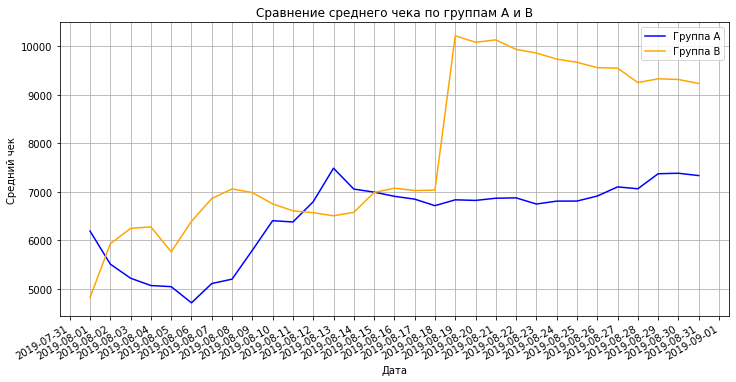

In [17]:
# конвертеры, которые позволяют использовать типы pandas в matplotlib 
register_matplotlib_converters()

datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'orderId': 'nunique',
            'userId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']
]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']
]

# Создаем график с указанным размером для среднего чека
plt.figure(figsize=(12, 6))

# Построим графики среднего чека по группам
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], label='Группа A', color='blue')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], label='Группа B', color='orange')

# Подписи осей
plt.xlabel('Дата')
plt.ylabel('Средний чек')

# Заголовок графика
plt.title('Сравнение среднего чека по группам A и B')

# Добавляем сетку для улучшения восприятия
plt.grid()

# Легенда
plt.legend()

# Форматирование даты на оси x для лучшей читаемости
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Вы можете настроить интервал как необходимо
plt.gcf().autofmt_xdate()  # Автоматически форматируем даты

# Показать график
plt.show()

Средний чек группы B имеет высокий скачок начиная с 18.08

### Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

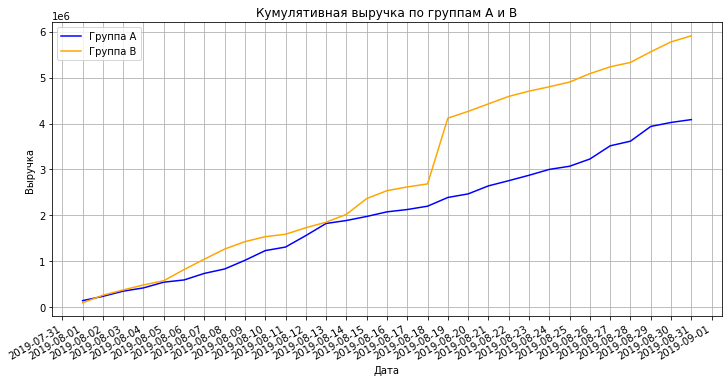

In [18]:
# Датафреймы с кумулятивным количеством заказов и кумулятивной выручкой по дням в группах A и B
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Создаем график с указанным размером
plt.figure(figsize=(12, 6))

# Строим график выручки для группы A
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Группа A', color='blue')

# Строим график выручки для группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Группа B', color='orange')

# Подписи осей
plt.xlabel('Дата')
plt.ylabel('Выручка')

# Заголовок графика
plt.title('Кумулятивная выручка по группам A и B')

# Добавляем сетку для улучшения восприятия
plt.grid()

# Легенда
plt.legend()

# Форматирование даты на оси X для лучшей читаемости
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Можно настроить интервал
plt.gcf().autofmt_xdate()  # Автоматически форматируем даты

# Показать график
plt.show()

Кумулятивная выручка в группе B резко возросла начиная с 18.08, видимо кто-то сделал аномально большой заказ

### Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

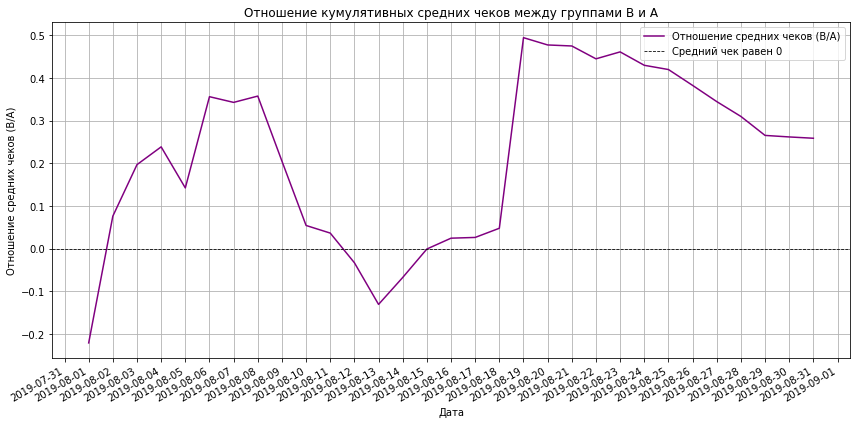

In [19]:
# Объединяем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# Рассчитываем отношение средних чеков
average_check_ratio = (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB']) / (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA']) - 1

# Создаем график
plt.figure(figsize=(12, 6))
plt.plot(mergedCumulativeRevenue['date'], average_check_ratio, color='purple', label='Отношение средних чеков (B/A)')

# Добавляем горизонтальную линию y=0 для удобства восприятия
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8, label='Средний чек равен 0')

# Добавляем подписи осей
plt.xlabel('Дата')
plt.ylabel('Отношение средних чеков (B/A)')

# Заголовок графика
plt.title('Отношение кумулятивных средних чеков между группами B и A')

# Добавляем легенду
plt.legend()

# Форматирование даты на оси X для лучшей читаемости
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Можно настроить интервал
plt.gcf().autofmt_xdate()  # Автоматически форматируем даты

# Показать график
plt.grid()  # Добавляем сетку для улучшения восприятия
plt.tight_layout()  # Автоматически корректируем подгруппы графика
plt.show()

Средний чек группы B практически все время превышает группу A. Была одна просадка в начале месяца, и 14.08, также виден скачок 18.08

### Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.

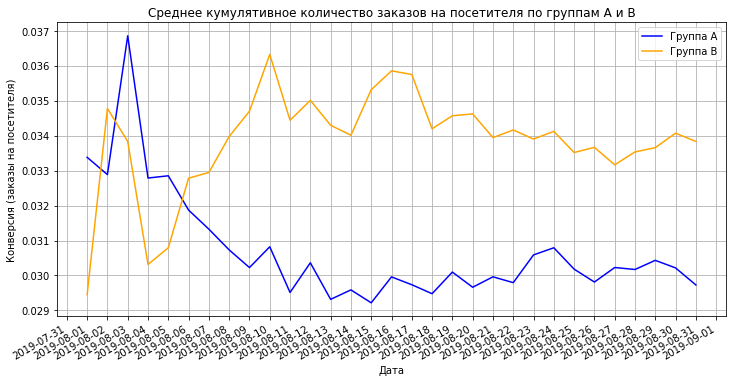

In [20]:
# Считаем среднее количество заказов на посетителя для каждой группы
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

# Создаём датафреймы с кумулятивным количеством заказов, выручкой и конверсией по дням в группах A и B
cumulativeConversionA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'conversion']]
cumulativeConversionB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'conversion']]

# Создаем график с указанным размером
plt.figure(figsize=(12, 6))

# Строим график для группы A
plt.plot(cumulativeConversionA['date'], cumulativeConversionA['conversion'], label='Группа A', color='blue')

# Строим график для группы B
plt.plot(cumulativeConversionB['date'], cumulativeConversionB['conversion'], label='Группа B', color='orange')

# Подписи осей
plt.xlabel('Дата')
plt.ylabel('Конверсия (заказы на посетителя)')

# Заголовок графика
plt.title('Среднее кумулятивное количество заказов на посетителя по группам A и B')

# Добавляем сетку для улучшения восприятия
plt.grid()

# Легенда
plt.legend()

# Форматирование даты на оси X для лучшей читаемости
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Настраиваем интервал для меток
plt.gcf().autofmt_xdate()  # Автоматически форматируем даты

# Показать график
plt.show()

Начиная с 07.08 среднее количество заказов на посетителя в группе B ушло в отрыв

### Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.

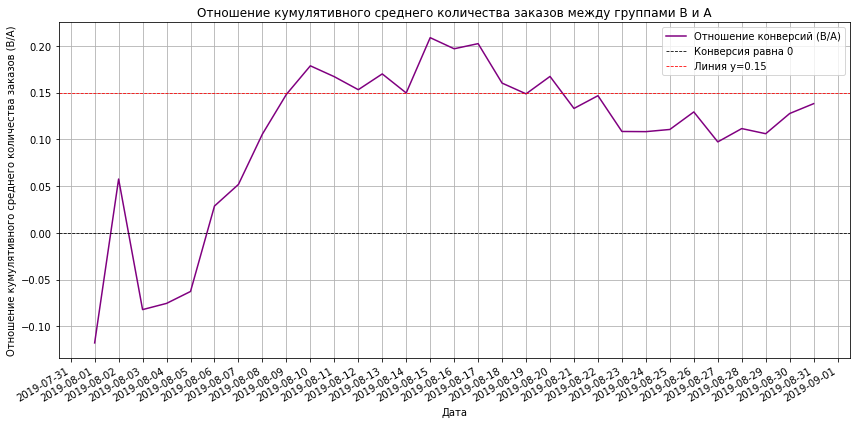

In [21]:
# Считаем среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

# Отделяем данные по группе A и B
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# Объединяем данные для групп A и B
mergedConversion = cumulativeDataA.merge(cumulativeDataB, on='date', how='left', suffixes=['A', 'B'])

# Рассчитываем отношение конверсий (B/A)
conversion_ratio = (mergedConversion['conversionB'] / mergedConversion['conversionA']) - 1

# Создаем график
plt.figure(figsize=(12, 6))
plt.plot(mergedConversion['date'], conversion_ratio, color='purple', label='Отношение конверсий (B/A)')

# Добавляем горизонтальную линию y=0 для удобства восприятия
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8, label='Конверсия равна 0')

# Добавляем горизонтальную линию y=0.15
plt.axhline(y=0.15, color='red', linestyle='--', linewidth=0.8, label='Линия y=0.15')

# Добавляем подписи осей
plt.xlabel('Дата')
plt.ylabel('Отношение кумулятивного среднего количества заказов (B/A)')

# Заголовок графика
plt.title('Отношение кумулятивного среднего количества заказов между группами B и A')

# Добавляем легенду
plt.legend()

# Форматирование даты на оси X для лучшей читаемости
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Можно настроить интервал
plt.gcf().autofmt_xdate()  # Автоматически форматируем даты

# Показать график
plt.grid()  # Добавляем сетку для улучшения восприятия
plt.tight_layout()  # Автоматически корректируем подгруппы графика
plt.show()

На этом графике также видно, что кумулятивное среднего количества заказов группы B резко возрасло с 07.08

### Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

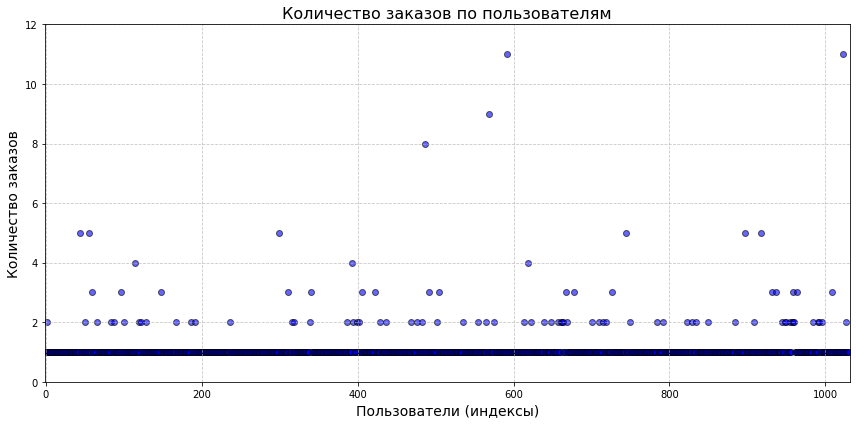

In [22]:
ordersByUsers = (
    orders.groupby('userId', as_index=False)
    .agg({'orderId': 'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']

# Создание оси X
x_values = pd.Series(range(0, len(ordersByUsers)))

# Создание графика
plt.figure(figsize=(12, 6))
plt.scatter(x_values, ordersByUsers['orders'], alpha=0.6, color='blue', edgecolor='black')

# Настройка осей
plt.xlabel('Пользователи (индексы)', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)

# Добавление заголовка
plt.title('Количество заказов по пользователям', fontsize=16)

# Добавление сетки для удобства восприятия
plt.grid(True, linestyle='--', alpha=0.7)

# Настройка лимитов осей
plt.xlim(-1, len(ordersByUsers))
plt.ylim(0, ordersByUsers['orders'].max() + 1)

# Показать график
plt.tight_layout()
plt.show()

В данных присутствуют выбросы

### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей

Границей выбросов в дальнейшем анализе буду считать 95й процентиль 

In [23]:
np.percentile(ordersByUsers['orders'], [90, 95, 99])
orders_percentile = 2

5% значений находятся за пределами 2 заказов на пользователя

### Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

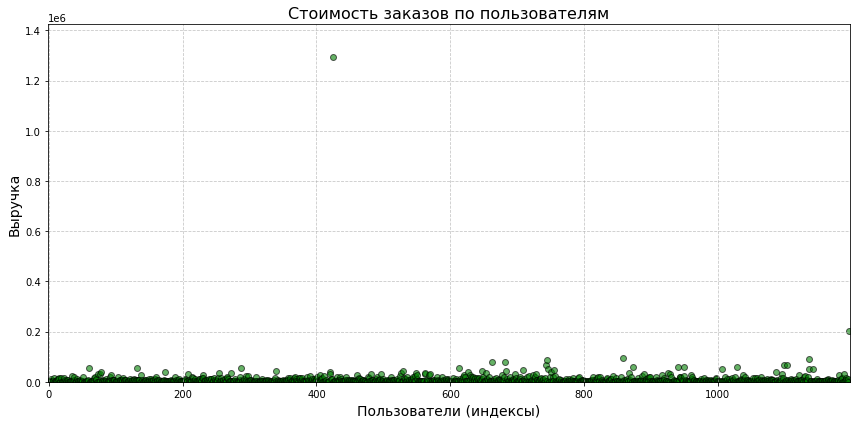

In [24]:
# Создание оси X для выручки
x_values = pd.Series(range(0, len(orders['revenue'])))

# Создание графика
plt.figure(figsize=(12, 6))
plt.scatter(x_values, orders['revenue'], alpha=0.6, color='green', edgecolor='black')

# Настройка осей
plt.xlabel('Пользователи (индексы)', fontsize=14)
plt.ylabel('Выручка', fontsize=14)

# Добавление заголовка
plt.title('Стоимость заказов по пользователям', fontsize=16)

# Добавление сетки для удобства восприятия
plt.grid(True, linestyle='--', alpha=0.7)

# Настройка лимитов осей
plt.xlim(-1, len(orders['revenue']))
plt.ylim(0, orders['revenue'].max() + (orders['revenue'].max() * 0.1))

# Показать график
plt.tight_layout()
plt.show()

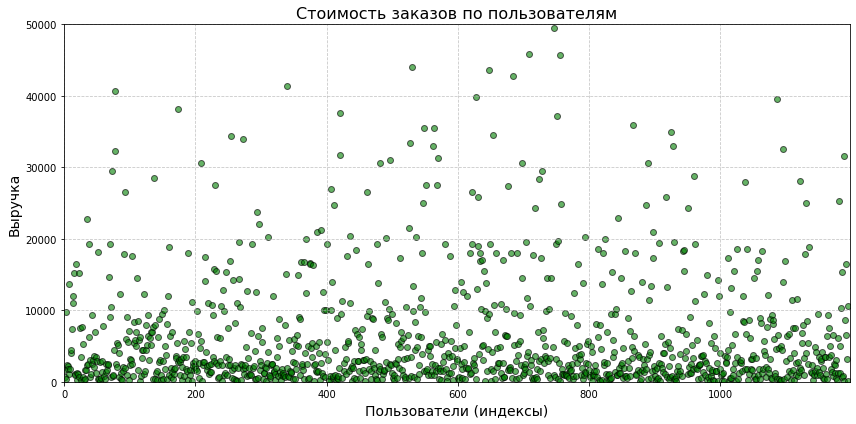

In [25]:
# Создание оси X для выручки
x_values = pd.Series(range(0, len(orders['revenue'])))

# Создание графика
plt.figure(figsize=(12, 6))
plt.scatter(x_values, orders['revenue'], alpha=0.6, color='green', edgecolor='black')

# Настройка осей
plt.xlabel('Пользователи (индексы)', fontsize=14)
plt.ylabel('Выручка', fontsize=14)

# Добавление заголовка
plt.title('Стоимость заказов по пользователям', fontsize=16)

# Добавление сетки для удобства восприятия
plt.grid(True, linestyle='--', alpha=0.7)

# Настройка лимитов осей
plt.xlim(-1, len(orders['revenue']))
plt.ylim(0, 50000)  # Ограничиваем выручку до 20000

# Показать график
plt.tight_layout()
plt.show()

В выручке на пользователя также есть аномалии

### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [26]:
np.percentile(orders['revenue'], [90, 95, 99])
revenue_percentile = 28000

5% значений находятся за пределами 28000 выручки на человека

### Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.

Для проверки гипотез буду использовать альфа 0.5. И использовать метод U-тест Манна-Уитни (также известном как тест ранговых сумм Манна-Уитни). Этот непараметрический тест применяется для сравнения двух независимых выборок, чтобы определить, есть ли статистически значимая разница между их распределениями. Метрика численная и имеет выбросы, которые мы не можем исключить без потери важной информации. Поэтому выбран данный метод.

Проверим гипотезу о равенстве групп в среднем количестве заказов на посетителя. 

H0: различий в среднем между группами нет.

H1: различия в среднем между группами есть.


In [27]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("P:value = {0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("B/A = {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

P-value значительно меньше 0.05, потому нулевую гипотезу отвергаем. Анализ «сырых данных» сообщает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы B к конверсии группы A равен 13.8%.

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

Проверим гипотезу о равенстве групп в среднем чеке заказа на посетителя. 

H0: различий в среднем между группами нет.

H1: различия в среднем между группами есть.

In [28]:
print('P-value = {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('B/A = {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value = 0.729
B/A = 0.259


P-value больше 0.05 — статистически значимых отличий в среднем чеке между группами нет. Кроме того, относительное различие среднего чека между сегментами всего 2.5%. Принимаем нулевую гипотезу. Статистически значимых различий между группами нет.

### Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.

Проверим гипотезу о равенстве групп в среднем чеке заказа на посетителя по очищенным данным. 

H0: различий в среднем между группами нет.

H1: различия в среднем между группами есть.

In [29]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > orders_percentile]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > orders_percentile]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > revenue_percentile]['userId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)


sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('P-value = {0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('B/A = {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

P-value = 0.01304
B/A = 0.173


P-value меньше 0.05, потому нулевую гипотезу отвергаем. В среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы B к конверсии группы A равен 17.3%. Нулевую гипотезу отвергаем.

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения

In [30]:
print(
    'P-value = {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "B/A = {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

P-value = 0.738
B/A = -0.020


P-value больше 0.05 — статистически значимых отличий в среднем чеке между группами нет. Относительное различие среднего чека между сегментами всего 0.2%. Принимаем нулевую гипотезу.

### Примите решение по результатам теста и объясните его. Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

**Выводы:**

Есть статистически значимое различие по среднему количеству заказов как по сырым данным, так и после фильтрации аномалий в пользу группы B.

По сырым данным, а также после удаления аномалий нет статистически значимого различия по среднему чеку между группами.

График различия количества заказов между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения.

График различия среднего чека хоть и имел просадки, но в целом езультаты группы B лучше группы A.

Останавливаем тест, фиксируем победу группы B. В группе B пользователи заказывают чаще, но стоимость заказа в среднем у групп не отличается. Можно сделать вывод, что что-то стимулирует группу B к более частым покупкам, в отличии от группы A.